In [70]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec

from datetime import datetime
from pprint import pprint

%matplotlib inline

# Credit Risk Score Prediction on Aave Protocol v2

*Disclaimer: this effort is made with limited knowledge on aave governance, and hence some assumptions are addressed as necessary.*

## 1. Exploratory and Analysis

The v2 protocol is chosen as it contains more recent data. On the other hand, the v1 protocol shows deposit history for the year 2020 for some reason. Based on the requirement, we query 100 addresses of `user` data together with their respective `unclaimedRewards`, `lifetimeRewards`, `incentivizedActions`, last 100 addresses of the `depositHistory`, `borrowHistory`, `repayHistory`, and `redeemUnderlyingHistory`.

In [71]:
# Source: https://towardsdatascience.com/how-to-develop-a-credit-risk-model-and-scorecard-91335fc01f03
# https://github.com/finlytics-hub/credit_risk_model
def run_query(query):

    # endpoint for making the request
    # https://api.thegraph.com/subgraphs/name/aave/protocol
    # https://api.thegraph.com/subgraphs/name/aave/protocol-multy-raw
    request = requests.post('https://api.thegraph.com/subgraphs/name/aave/protocol-v2'
                            '',
                            json={'query': query})
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception('Query failed. return code is {}.      {}'.format(request.status_code, query))

In [72]:
users_query = """
{
  users(where: {
    id_not_in: ["0x0000000000000000000000000000000000000001",
                "0x000000000000000000000000000000000000dead"]
  }){
    id
    unclaimedRewards
    lifetimeRewards
    depositHistory(orderBy: timestamp, orderDirection: desc,) {
      id
      amount
      timestamp
      reserve {
        symbol
        name
        price{
          priceInEth
        }
        liquidityRate
        variableBorrowRate
        stableBorrowRate
      }
    }
    borrowHistory(orderBy: timestamp, orderDirection: desc) {
      id
      amount
      timestamp
      reserve {
        symbol
        name
        price{
          priceInEth
        }
        liquidityRate
        variableBorrowRate
        stableBorrowRate
      }
      borrowRate
      borrowRateMode
      stableTokenDebt
      variableTokenDebt
    }
    repayHistory(orderBy: timestamp, orderDirection: desc){
      id
      amount
      timestamp
      reserve{
        symbol
        name
        price{
          priceInEth
        }
        liquidityRate
        variableBorrowRate
        stableBorrowRate
      }
    }
    redeemUnderlyingHistory(orderBy: timestamp, orderDirection: desc){
      id
      amount
      timestamp
      reserve{
        symbol
        name
        price{
          priceInEth
        }
        liquidityRate
        variableBorrowRate
        stableBorrowRate
      }
    }
    incentivizedActions{
      id
      amount
    }
  }
}
"""


In [73]:
users_result = run_query(users_query)
#pprint(user_result)
#users_result['data']['users']

In [74]:
def extract_deposit_history(user_id, deposit=None):
    """
    Extract deposit history from a given user
    """
        
    deposit_dict = dict(
        user_id = user_id,
        deposit_reserve_name = '',
        deposit_reserve_symbol = '',
        deposit_reserve_priceInEth = 0,
        deposit_reserve_liquidityRate = 0,
        deposit_reserve_variableBorrowRate = 0,
        deposit_reserve_stableBorrowRate = 0,
        deposit_amount = 0,
        deposit_timestamp_unix = None,
        deposit_timestamp = None
    )
    
    if deposit:
        deposit_dict['deposit_reserve_name'] = deposit['reserve']['name']
        deposit_dict['deposit_reserve_symbol'] = deposit['reserve']['symbol']
        deposit_dict['deposit_reserve_priceInEth'] = int(deposit['reserve']['price']['priceInEth'])
        deposit_dict['deposit_reserve_liquidityRate'] = int(deposit['reserve']['liquidityRate'])
        deposit_dict['deposit_reserve_variableBorrowRate'] = int(deposit['reserve']['variableBorrowRate'])
        deposit_dict['deposit_reserve_stableBorrowRate'] = int(deposit['reserve']['stableBorrowRate'])
        deposit_dict['deposit_amount'] = int(deposit['amount'])
        deposit_dict['deposit_timestamp_unix'] = deposit['timestamp']
        deposit_dict['deposit_timestamp'] = pd.to_datetime(deposit['timestamp'], 
                                                           unit='s', errors='ignore')
        
    return deposit_dict

def extract_borrow_history(user_id, borrow=None):
    """
    Extract borrow history from a given user
    """
    borrow_dict = dict(
        user_id = user_id,
        borrow_reserve_name = '',
        borrow_reserve_symbol = '',
        borrow_reserve_priceInEth = 0,
        borrow_reserve_liquidityRate = 0,
        borrow_reserve_variableBorrowRate = 0,
        borrow_reserve_stableBorrowRate = 0,
        borrow_amount = 0,
        borrow_timestamp_unix = None,
        borrow_timestamp = None,
        borrow_rate = 0,
        borrow_rate_mode = '',
        borrow_stableTokenDebt = 0,
        borrow_variableTokenDebt = 0
        #borrow_accrued_interest = 0
    )
    
    if borrow:
        borrow_dict['borrow_reserve_name'] = borrow['reserve']['name']
        borrow_dict['borrow_reserve_symbol'] = borrow['reserve']['symbol']
        borrow_dict['borrow_reserve_priceInEth'] = int(borrow['reserve']['price']['priceInEth'])
        borrow_dict['borrow_reserve_liquidityRate'] = int(borrow['reserve']['liquidityRate'])
        borrow_dict['borrow_reserve_variableBorrowRate'] = int(borrow['reserve']['variableBorrowRate'])
        borrow_dict['borrow_reserve_stableBorrowRate'] = int(borrow['reserve']['stableBorrowRate'])
        borrow_dict['borrow_amount'] = int(borrow['amount'])
        borrow_dict['borrow_timestamp_unix'] = borrow['timestamp']
        borrow_dict['borrow_timestamp'] = pd.to_datetime(borrow['timestamp'],
                                                         unit='s', errors='ignore')
        borrow_dict['borrow_rate'] = int(borrow['borrowRate'])
        borrow_dict['borrow_rate_mode'] = borrow['borrowRateMode']
        borrow_dict['borrow_stableTokenDebt'] = int(borrow['stableTokenDebt'])
        borrow_dict['borrow_variableTokenDebt'] = int(borrow['variableTokenDebt'])
        #borrow_dict['borrow_accrued_interest'] = int(borrow['accruedBorrowInterest'])
    
    return borrow_dict

def extract_repay_history(user_id, repay=None):
    """
    Extract repay history from a given user
    """
    repay_dict = dict(
        user_id = user_id,
        repay_reserve_name = '',
        repay_reserve_symbol = '',
        repay_reserve_priceInEth = 0,
        repay_reserve_liquidityRate = 0,
        repay_reserve_variableBorrowRate = 0,
        repay_reserve_stableBorrowRate = 0,
        repay_amount = 0,
        repay_timestamp_unix = None,
        repay_timestamp = None
    )
    
    if repay:
        repay_dict['repay_reserve_name'] = repay['reserve']['name']
        repay_dict['repay_reserve_symbol'] = repay['reserve']['symbol']
        repay_dict['repay_reserve_priceInEth'] = int(repay['reserve']['price']['priceInEth'])
        repay_dict['repay_reserve_liquidityRate'] = int(repay['reserve']['liquidityRate'])
        repay_dict['repay_reserve_variableBorrowRate'] = int(repay['reserve']['variableBorrowRate'])
        repay_dict['repay_reserve_stableBorrowRate'] = int(repay['reserve']['stableBorrowRate'])
        repay_dict['repay_amount'] = int(repay['amount'])
        repay_dict['repay_timestamp_unix'] = repay['timestamp']
        repay_dict['repay_timestamp'] = pd.to_datetime(repay['timestamp'],
                                                       unit='s', errors='ignore')

    return repay_dict


def extract_redeemUnderlying_history(user_id, redeem=None):
    
    redeem_dict = dict(
        user_id = user_id,
        redeem_reserve_name = '',
        redeem_reserve_symbol = '',
        redeem_reserve_priceInEth = 0,
        redeem_reserve_liquidityRate = 0,
        redeem_reserve_variableBorrowRate = 0,
        redeem_reserve_stableBorrowRate = 0,
        redeem_amount = 0,
        redeem_timestamp_unix = None,
        redeem_timestamp = None
    )
    
    if redeem:
        redeem_dict['redeem_reserve_name'] = redeem['reserve']['name']
        redeem_dict['redeem_reserve_symbol'] = redeem['reserve']['symbol']
        redeem_dict['redeem_reserve_priceInEth'] = int(redeem['reserve']['price']['priceInEth'])
        redeem_dict['redeem_reserve_liquidityRate'] = int(redeem['reserve']['liquidityRate'])
        redeem_dict['redeem_reserve_variableBorrowRate'] = int(redeem['reserve']['variableBorrowRate'])
        redeem_dict['redeem_reserve_stableBorrowRate'] = int(redeem['reserve']['stableBorrowRate'])
        redeem_dict['redeem_amount'] = int(redeem['amount'])
        redeem_dict['redeem_timestamp_unix'] = int(redeem['timestamp'])
        redeem_dict['redeem_timestamp'] = pd.to_datetime(redeem['timestamp'],
                                                         unit='s', errors='ignore')

    return redeem_dict
    



In [75]:
users, deposits, borrows, repays, redeems = [], [], [], [], []
for user in users_result['data']['users']:
    #print(user, '\n')
    
    user_id = user['id']
        
    users.append(dict(
        user_id = user_id,
        user_unclaimedRewards = int(user['unclaimedRewards']),
        user_lifetimeRewards = int(user['lifetimeRewards']),
        user_incentivizedActions = int(user['incentivizedActions'][0]['amount']) \
            if user['incentivizedActions'] else 0
    ))
    
    # extract depositHistory
    if user['depositHistory']:
        for deposit in user['depositHistory']:
            deposit_dict = extract_deposit_history(user_id, deposit)
            deposits.append(deposit_dict)
    else:
        deposit_dict = extract_deposit_history(user_id)
        deposits.append(deposit_dict)
    
    # extract borrowHistory
    if user['borrowHistory']:
        for borrow in user['borrowHistory']:
            borrow_dict = extract_borrow_history(user_id, borrow)
            borrows.append(borrow_dict)
    else:
        borrow_dict = extract_borrow_history(user_id)
        borrows.append(borrow_dict)
   
    # extract repayHistory
    if user['repayHistory']:
        for repay in  user['repayHistory']:
            repay_dict = extract_repay_history(user_id, repay)
            repays.append(repay_dict)
    else:
        repay_dict = extract_repay_history(user_id)
        repays.append(repay_dict)
        
    # extract redeemUnderlyingHistory
    if user['redeemUnderlyingHistory']:
        for redeem in user['redeemUnderlyingHistory']:
            redeem_dict = extract_redeemUnderlying_history(user_id, redeem)
            redeems.append(redeem_dict)
    else:
        redeem_dict = extract_redeemUnderlying_history(user_id)
        redeems.append(redeem_dict)
            

In [76]:
users_df = pd.DataFrame(users).astype({
    'user_unclaimedRewards': 'float64',
    'user_lifetimeRewards': 'float64',
    'user_incentivizedActions': 'float64'
})
users_df.head()

,user_id,user_unclaimedRewards,user_lifetimeRewards,user_incentivizedActions
0,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,4.600000e+01,4.600000e+01,4.000000e+00
1,0x00000000000cd56832ce5dfbcbff02e7ec639bc9,7.217727e+15,7.217727e+15,2.964439e+15
2,0x00000000005dbcb0d0513fcda746382fe8a53468,0.000000e+00,0.000000e+00,0.000000e+00
3,0x00000000009a41862f3b2b0c688b7c0d1940511e,0.000000e+00,0.000000e+00,0.000000e+00
4,0x0000000000d41c96294ccdac8612bdfe29c641af,0.000000e+00,0.000000e+00,0.000000e+00


### 1.1. No. of user with no rewards / incentivized actions and deposits / borrows

In [77]:

print(f'no unclaimed rewards: {len(users_df[users_df.user_unclaimedRewards == 0])}')
print(f'no lifetime rewards: {len(users_df[users_df.user_lifetimeRewards == 0])}')
print(f'no incentivized actions: {len(users_df[users_df.user_incentivizedActions == 0])}')


no unclaimed rewards: 69
no lifetime rewards: 63
no incentivized actions: 63


Out of 100 users, there are 6 users with lifetime rewards and incentivized actions but do not have unclaimed rewards. And there are 2 users that have not claimed all the lifetime rewards.

In [78]:
users_df[users_df.user_unclaimedRewards != users_df.user_lifetimeRewards]

,user_id,user_unclaimedRewards,user_lifetimeRewards,user_incentivizedActions
40,0x00137878c7c179cad13505c18c86fd84623f04c7,0.000000e+00,1.643452e+18,5.149035e+08
42,0x0013eb108d5168bf2285f0f54172394f7c17d17d,0.000000e+00,7.243024e+18,7.243024e+18
43,0x0014a4f88a92d3924a3f553dc51c290ce06ae125,4.519764e+16,1.334680e+19,3.866509e+18
58,0x002ad2406d6d05e0c58e39af6eb506f762e9f7bb,0.000000e+00,2.954459e+18,3.784487e+17
64,0x0032311e56bc34efde20b408bb99d986eea1863a,8.852672e+16,4.770834e+17,1.388911e+16
80,0x00405dc6b34d782df3feb0f0ec308fc27d4bd6bb,0.000000e+00,3.802339e+18,7.052461e+17
90,0x004c350cd1ab72ea28cd6c47935b5bb31f64a928,0.000000e+00,1.305511e+18,6.943395e+17
92,0x004f137c71b3003c7915bd6aa3a4f57e334a738e,0.000000e+00,2.907850e+17,7.974066e+16


In [79]:
deposits_df = pd.DataFrame(deposits).astype({
    'deposit_reserve_priceInEth': 'float64',
    'deposit_reserve_liquidityRate': 'float64',
    'deposit_reserve_variableBorrowRate': 'float64',
    'deposit_reserve_stableBorrowRate': 'float64',
    'deposit_amount': 'float64'
})
deposits_df.head()

,user_id,deposit_reserve_name,deposit_reserve_symbol,deposit_reserve_priceInEth,deposit_reserve_liquidityRate,deposit_reserve_variableBorrowRate,deposit_reserve_stableBorrowRate,deposit_amount,deposit_timestamp_unix,deposit_timestamp
0,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1.000000e+18,2.473758e+23,5.640864e+24,3.705108e+25,1.270902e+17,1.626330e+09,2021-07-15 06:18:08
1,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1.000000e+18,2.473758e+23,5.640864e+24,3.705108e+25,1.156952e+17,1.626201e+09,2021-07-13 18:30:44
2,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1.000000e+18,2.473758e+23,5.640864e+24,3.705108e+25,1.150193e+17,1.626196e+09,2021-07-13 17:00:22
3,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1.000000e+18,2.473758e+23,5.640864e+24,3.705108e+25,1.321669e+17,1.626074e+09,2021-07-12 07:16:40
4,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1.000000e+18,2.473758e+23,5.640864e+24,3.705108e+25,1.145805e+17,1.625835e+09,2021-07-09 12:50:26


In [80]:
borrows_df = pd.DataFrame(borrows).astype({
    'borrow_reserve_priceInEth': 'float64',
    'borrow_reserve_liquidityRate': 'float64',
    'borrow_reserve_variableBorrowRate' : 'float64',
    'borrow_amount': 'float64',
    'borrow_rate': 'float64',
    'borrow_stableTokenDebt': 'float64',
    'borrow_variableTokenDebt': 'float64'
})
borrows_df.head()

,user_id,borrow_reserve_name,borrow_reserve_symbol,borrow_reserve_priceInEth,borrow_reserve_liquidityRate,borrow_reserve_variableBorrowRate,borrow_reserve_stableBorrowRate,borrow_amount,borrow_timestamp_unix,borrow_timestamp,borrow_rate,borrow_rate_mode,borrow_stableTokenDebt,borrow_variableTokenDebt
0,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,,,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,NaN,NaT,0.000000e+00,,0.0,0.000000e+00
1,0x00000000000cd56832ce5dfbcbff02e7ec639bc9,Synthetix Network Token,SNX,3.576402e+15,4.269595e+25,1.153888e+26,0,5.000000e+21,1.622545e+09,2021-06-01 11:00:43,1.273128e+26,Variable,0.0,4.760354e+21
2,0x00000000000cd56832ce5dfbcbff02e7ec639bc9,Republic Token,REN,1.590700e+14,9.807357e+23,1.440713e+25,20581609881463016033901143,1.000000e+23,1.622303e+09,2021-05-29 15:35:30,8.024004e+24,Variable,0.0,9.874062e+22
3,0x00000000005dbcb0d0513fcda746382fe8a53468,,,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,NaN,NaT,0.000000e+00,,0.0,0.000000e+00
4,0x00000000009a41862f3b2b0c688b7c0d1940511e,,,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,NaN,NaT,0.000000e+00,,0.0,0.000000e+00


Observing the deposit and borrow history from the dataset, there are 23 users with no past deposit, 69 users with no past borrow, and 16 users with no past deposit and borrow. Therefore, we will purge these 16 users from the dataset.

In [81]:
no_deposits = set(deposits_df[deposits_df.deposit_amount == 0].user_id)
no_borrows = set(borrows_df[borrows_df.borrow_amount == 0].user_id)

print(f'no deposits: {len(no_deposits)}')
print(f'no borrows: {len(no_borrows)}')

no_transactions = list(no_deposits.intersection(no_borrows))
print(f'no transactions: {len(no_transactions)}') 


no deposits: 23
no borrows: 69
no transactions: 16


In [82]:
# drop user, deposit, and borrow with no transaction
users_df.drop(users_df[users_df.user_id.isin(no_transactions)].index, inplace=True)
deposits_df.drop(deposits_df[deposits_df.user_id.isin(no_transactions)].index, inplace=True)
borrows_df.drop(borrows_df[borrows_df.user_id.isin(no_transactions)].index, inplace=True)

In [83]:
repays_df = pd.DataFrame(repays).astype({
    'repay_reserve_priceInEth': 'float64',
    'repay_reserve_liquidityRate': 'float64',
    'repay_reserve_variableBorrowRate': 'float64',
    'repay_reserve_stableBorrowRate': 'float64',
    'repay_amount': 'float64'    
})
repays_df.head()

,user_id,repay_reserve_name,repay_reserve_symbol,repay_reserve_priceInEth,repay_reserve_liquidityRate,repay_reserve_variableBorrowRate,repay_reserve_stableBorrowRate,repay_amount,repay_timestamp_unix,repay_timestamp
0,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,,,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaT
1,0x00000000000cd56832ce5dfbcbff02e7ec639bc9,Synthetix Network Token,SNX,3.576402e+15,4.269595e+25,1.153888e+26,0.000000e+00,5.000478e+21,1.622568e+09,2021-06-01 17:21:43
2,0x00000000000cd56832ce5dfbcbff02e7ec639bc9,Republic Token,REN,1.590700e+14,9.807357e+23,1.440713e+25,2.058161e+25,1.000008e+23,1.622335e+09,2021-05-30 00:42:31
3,0x00000000005dbcb0d0513fcda746382fe8a53468,,,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaT
4,0x00000000009a41862f3b2b0c688b7c0d1940511e,,,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaT


In [84]:
redeems_df = pd.DataFrame(redeems).astype({
    'redeem_reserve_priceInEth': 'float64',
    'redeem_reserve_liquidityRate': 'float64',
    'redeem_reserve_variableBorrowRate': 'float64',
    'redeem_reserve_stableBorrowRate': 'float64',
    'redeem_amount': 'float64'
})
redeems_df.head()

,user_id,redeem_reserve_name,redeem_reserve_symbol,redeem_reserve_priceInEth,redeem_reserve_liquidityRate,redeem_reserve_variableBorrowRate,redeem_reserve_stableBorrowRate,redeem_amount,redeem_timestamp_unix,redeem_timestamp
0,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1.000000e+18,2.473758e+23,5.640864e+24,3.705108e+25,1.317387e+17,1.626760e+09,2021-07-20 05:48:47
1,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1.000000e+18,2.473758e+23,5.640864e+24,3.705108e+25,1.259542e+17,1.626443e+09,2021-07-16 13:45:12
2,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1.000000e+18,2.473758e+23,5.640864e+24,3.705108e+25,9.442046e+16,1.624069e+09,2021-06-19 02:21:09
3,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1.000000e+18,2.473758e+23,5.640864e+24,3.705108e+25,8.139624e+16,1.623842e+09,2021-06-16 11:12:51
4,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1.000000e+18,2.473758e+23,5.640864e+24,3.705108e+25,1.734259e+17,1.621815e+09,2021-05-24 00:03:22


Similarly, we want to drop the users with no past deposit and borrow from the repay and redeem history

In [85]:
repays_df.drop(repays_df[repays_df.user_id.isin(no_transactions)].index, inplace=True)
redeems_df.drop(redeems_df[redeems_df.user_id.isin(no_transactions)].index, inplace=True)

### 1.2. Standardizing the timestamp range

In [86]:
print(f'deposit timestamp range: {deposits_df.deposit_timestamp.min()} - {deposits_df.deposit_timestamp.max()}')
print(f'borrow timestamp range: {borrows_df.borrow_timestamp.min()} - {borrows_df.borrow_timestamp.max()}')
print(f'repay timestamp range: {repays_df.repay_timestamp.min()} - {repays_df.repay_timestamp.max()}')
print(f'redeem timestamp range: {redeems_df.redeem_timestamp.min()} - {redeems_df.redeem_timestamp.max()}')

deposit timestamp range: 2020-12-05 06:51:40 - 2021-08-01 22:15:00
borrow timestamp range: 2020-12-08 12:13:34 - 2021-08-01 10:44:24
repay timestamp range: 2020-12-31 10:54:18 - 2021-07-28 09:25:22
redeem timestamp range: 2020-12-25 13:45:52 - 2021-07-27 11:35:58


As can be seen that the timestamp range among the deposit, borrow, repay, and redeem history are different. We are assuming that we will include the last 6 months data.

In [87]:
# offset to 6 month data
offset = pd.Timestamp.today().date() - pd.DateOffset(months=6)
print(offset)
deposits_df = deposits_df[deposits_df.deposit_timestamp > offset]
borrows_df = borrows_df[borrows_df.borrow_timestamp > offset]
repays_df = repays_df[repays_df.repay_timestamp > offset]
redeems_df = redeems_df[redeems_df.redeem_timestamp > offset]


2021-02-05 00:00:00


### 1.3. Standardizing and aggregating the amount

Because of the underlying reserve variation, we want to make sure that the amount has a standardized cryptocurrency metric. We will use Eth, and so we are dividing the amount with price in Eth.

In [88]:
deposits_df['deposit_amountInEth'] = deposits_df['deposit_amount'] / deposits_df['deposit_reserve_priceInEth']
borrows_df['borrow_amountInEth'] = borrows_df['borrow_amount'] / borrows_df['borrow_reserve_priceInEth']
repays_df['repay_amountInEth'] = repays_df['repay_amount'] / repays_df['repay_reserve_priceInEth']
redeems_df['redeem_amountInEth'] = redeems_df['redeem_amount'] / redeems_df['redeem_reserve_priceInEth']

Next, we want to summarize the amount by `user_id` and `reserve_symbol` to obtain the total amount of deposit, borrow, repay, and redeem, respectively, for the past 6 months.

In [89]:
depositsAgg_df = deposits_df.groupby(['user_id', 'deposit_reserve_symbol'], as_index=False) \
    .agg({'deposit_amount': 'sum', 'deposit_amountInEth': 'sum'})
borrowsAgg_df = borrows_df.groupby(['user_id', 'borrow_reserve_symbol'], as_index=False) \
    .agg({'borrow_amount': 'sum', 'borrow_amountInEth': 'sum'})
repaysAgg_df = repays_df.groupby(['user_id', 'repay_reserve_symbol'], as_index=False) \
    .agg({'repay_amount': 'sum', 'repay_amountInEth': 'sum'})
redeemsAgg_df = redeems_df.groupby(['user_id', 'redeem_reserve_symbol'], as_index=False) \
    .agg({'redeem_amount': 'sum', 'redeem_amountInEth': 'sum'})

And finally, we want to merge all the deposits, borrows, repays, and redeems into a single dataframe.

In [90]:
transactions_df = pd.merge(users_df, depositsAgg_df, how='outer', on='user_id').drop(columns='deposit_amount')
transactions_df = pd.merge(transactions_df, borrowsAgg_df, how='outer', left_on=['user_id', 'deposit_reserve_symbol'],
                          right_on=['user_id', 'borrow_reserve_symbol']).drop(columns='borrow_amount')
transactions_df = pd.merge(transactions_df, repaysAgg_df, how='outer', left_on=['user_id', 'borrow_reserve_symbol'],
                          right_on=['user_id', 'repay_reserve_symbol']).drop(columns='repay_amount')
transactions_df = pd.merge(transactions_df, redeemsAgg_df, how='outer', left_on=['user_id', 'deposit_reserve_symbol'],
                          right_on=['user_id', 'redeem_reserve_symbol']).drop(columns='redeem_amount')

We notice that some of the rewards and incentivized actions are null because of outer join operations, so we want to fill that values with similar values as the respective users' rewards and incentivized actions.

In [91]:
# create lookup dataframe for user_unclaimedRewards, user_lifetimeRewards, user_incentivizedActions
lookup = transactions_df[~transactions_df['user_unclaimedRewards'].isnull()] \
    .groupby('user_id', as_index=False).first()[['user_id', 'user_unclaimedRewards', 'user_lifetimeRewards', 
                                                 'user_incentivizedActions']]

# fill the null because of merge dataframe with the same value as respective users' rewards
for row in lookup.itertuples():
    transactions_df['user_unclaimedRewards'].mask((transactions_df['user_unclaimedRewards'].isnull()) &
                                                 (transactions_df['user_id'] == row.user_id), 
                                                  row.user_unclaimedRewards, inplace=True)
    transactions_df['user_lifetimeRewards'].mask((transactions_df['user_lifetimeRewards'].isnull()) &
                                                 (transactions_df['user_id'] == row.user_id), 
                                                  row.user_lifetimeRewards, inplace=True)
    transactions_df['user_incentivizedActions'].mask((transactions_df['user_incentivizedActions'].isnull()) &
                                                 (transactions_df['user_id'] == row.user_id), 
                                                  row.user_incentivizedActions, inplace=True)

We also notice that there are records where there is no transactions because of this outer join operations. We want to drop these records.

In [92]:
# further filtering for all amount cols are NaN and reward cols are zero
amount_cols = ['deposit_amountInEth','borrow_amountInEth', 'repay_amountInEth', 'redeem_amountInEth']
rewards_cols = ['user_unclaimedRewards', 'user_lifetimeRewards', 'user_incentivizedActions']
nanAmount_zeroRewards = transactions_df[(transactions_df[amount_cols].isna().all(1)) & 
                          ((transactions_df[rewards_cols] == 0).all(1))]

nanAmount_zeroRewards

,user_id,user_unclaimedRewards,user_lifetimeRewards,user_incentivizedActions,deposit_reserve_symbol,deposit_amountInEth,borrow_reserve_symbol,borrow_amountInEth,repay_reserve_symbol,repay_amountInEth,redeem_reserve_symbol,redeem_amountInEth
4,0x00000000009a41862f3b2b0c688b7c0d1940511e,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,0x00080000158a9930aeb508823103b0a977161c47,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,0x000a08a296208bb5152221e878169609fc044ba9,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,0x000ba2873dbf3fed35d974d3bcbb8ed68fabdfa9,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,0x002190e2f72c750bdca1784c3b1344fc2f785992,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,0x0034daf2e65f6ef82bc6f893dbbfd7c232a0e59c,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,0x003c06a6168e9d2474e2c7f588d819b75f8025e5,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,0x0049c977aaf22e0db89b2755482c7e49ee2dc2dd,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,0x004afb002e3fb33c833fc16b6b63103bbf97312d,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
transactions_df.drop(nanAmount_zeroRewards.index, inplace=True)

In [94]:
# dividing reward amount to wei unit
for col in rewards_cols:
    transactions_df[col] = transactions_df[col] / 1e+18

Finally, we want to standardized the rewards and incentived actions amount by dividing them with wei unit of 1+e18. 

For visualization, we are aggregating each transactions by the reserve symbols to compare the transactions amount  in ETH for each reserve symbols.

In [95]:
# sum the amount in ETH by the reserve symbol
deposits_group = transactions_df.sort_values('deposit_reserve_symbol') \
    .groupby('deposit_reserve_symbol', as_index=False) \
    .agg({'deposit_amountInEth': 'sum'}).set_index('deposit_reserve_symbol')

borrows_group = transactions_df.sort_values('borrow_reserve_symbol') \
    .groupby('borrow_reserve_symbol', as_index=False) \
    .agg({'borrow_amountInEth': 'sum'}).set_index('borrow_reserve_symbol')

repays_group = transactions_df.sort_values('repay_reserve_symbol') \
    .groupby('repay_reserve_symbol', as_index=False) \
    .agg({'repay_amountInEth': 'sum'}).set_index('repay_reserve_symbol')

redeems_group = transactions_df.sort_values('redeem_reserve_symbol') \
    .groupby('redeem_reserve_symbol', as_index=False) \
    .agg({'redeem_amountInEth': 'sum'}).set_index('redeem_reserve_symbol')



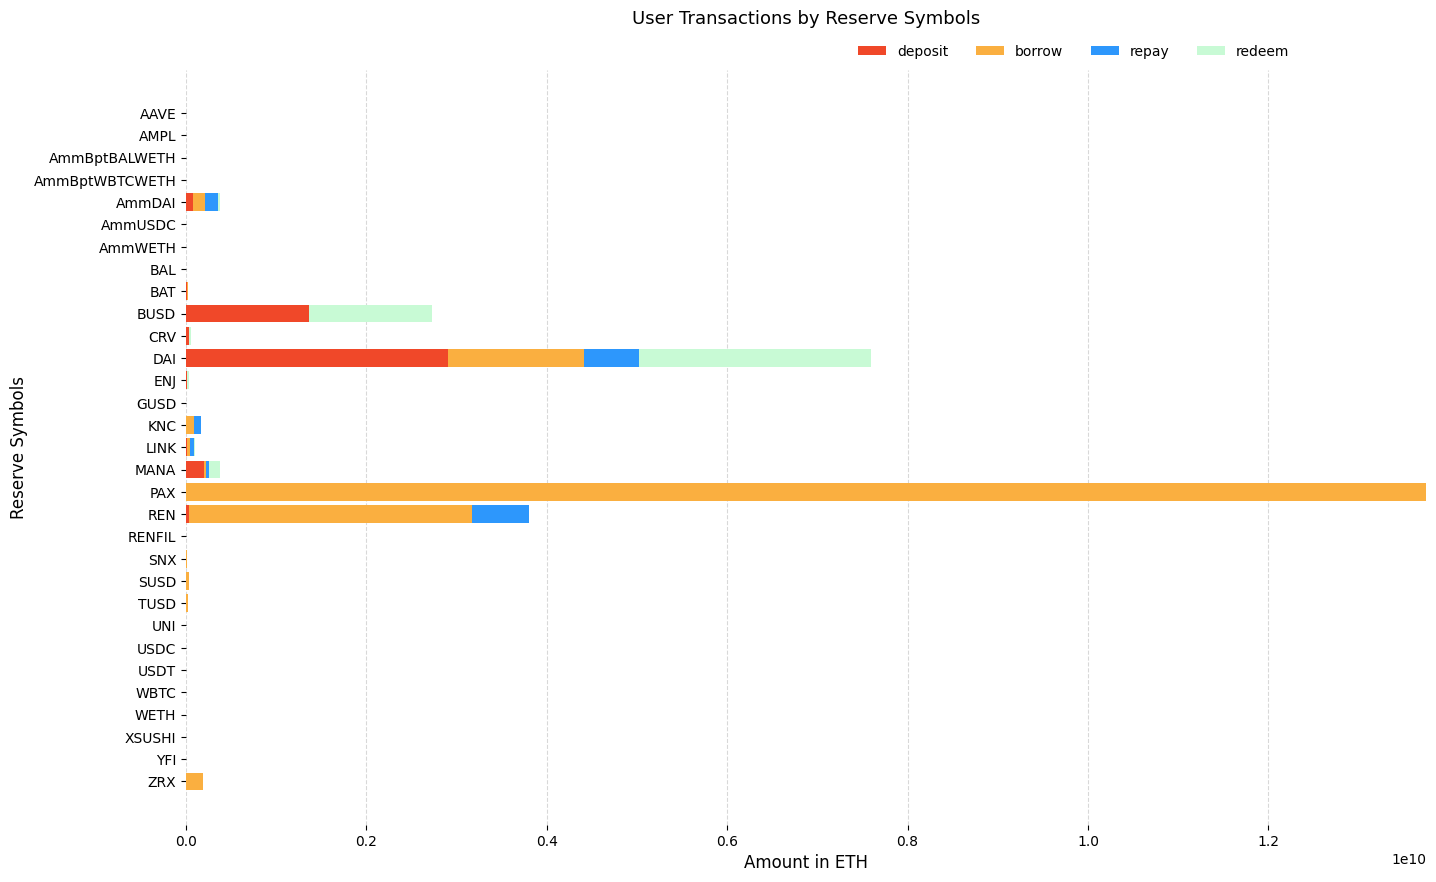

In [96]:
# merge and sort all the reserve symbols for y-axis value
y_labels = sorted(list(set(np.concatenate([deposits_group.index.values,
                        borrows_group.index.values, 
                        repays_group.index.values, 
                        redeems_group.index.values]))))

# obtain the transactions amount in eth for all the available reserve symbols for x-axis values
x_deposits = [deposits_group.loc[idx, 'deposit_amountInEth'] if idx in deposits_group.index.values else 0 
              for idx in y_labels]

x_borrows = [borrows_group.loc[idx, 'borrow_amountInEth'] if idx in borrows_group.index.values else 0 
              for idx in y_labels]

x_repays = [repays_group.loc[idx, 'repay_amountInEth'] if idx in repays_group.index.values else 0 
              for idx in y_labels]

x_redeems = [redeems_group.loc[idx, 'redeem_amountInEth'] if idx in redeems_group.index.values else 0 
              for idx in y_labels]

spectral_palette = {
    'red': '#F04829',
    'yellow': '#FAAF40',
    'blue': '#2D97FC',
    'green': '#C8FAD5'
}

height = 0.8

fig = plt.figure(figsize=(16, 10), dpi=100)
ax = fig.add_subplot(111)

labels = ['deposit', 'borrow', 'repay', 'redeem']
x_values = [x_deposits, x_borrows, x_repays, x_redeems]
colors = [spectral_palette['red'], spectral_palette['yellow'], 
          spectral_palette['blue'], spectral_palette['green']]

# create stacked barh plot
left = len(y_labels) * [0]
for x_value, label, color in zip(x_values, labels, colors):
    ax.barh(y_labels, x_value, label=label, color=color, height=height, left=left)
    left = np.add(left, x_value)

ax.invert_yaxis()
ax.legend(labels, bbox_to_anchor=([0.9, 1.05, 0, 0]), ncol=4, frameon=False)
ax.set_title('User Transactions by Reserve Symbols', y = 1.05, fontweight = 'light', fontsize = 13)
ax.set_xlabel('Amount in ETH', ha='center', fontsize = 12)
ax.set_ylabel('Reserve Symbols', ha='center', fontsize = 12)

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# adjust limits and draw grid lines
#plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed', alpha=0.3)



We notice that total borrow transaction amount for `PAX` is exorbitant as compared to the remaining transactions. This is a good indicator of using either `MinMaxScaler` or `StandardScaler` as part of the pipeline.

Investigating further, this user `0x0000006daea1723962647b7e189d311d757fb793` is a very active user for the past 6 months.

In [97]:
max_borrow = borrowsAgg_df[borrowsAgg_df.borrow_amountInEth == borrowsAgg_df.borrow_amountInEth.max()]
print(f'User with largest borrow amount (user_id, borrow_amountInEth): {max_borrow.user_id.values[0]}, {max_borrow.borrow_amountInEth.values[0]}')

transactions_df[transactions_df.user_id == max_borrow.user_id.values[0]]


User with largest borrow amount (user_id, borrow_amountInEth): 0x0000006daea1723962647b7e189d311d757fb793, 13748505597.217693


,user_id,user_unclaimedRewards,user_lifetimeRewards,user_incentivizedActions,deposit_reserve_symbol,deposit_amountInEth,borrow_reserve_symbol,borrow_amountInEth,repay_reserve_symbol,repay_amountInEth,redeem_reserve_symbol,redeem_amountInEth
12,0x0000006daea1723962647b7e189d311d757fb793,12.000794,12.000794,0.000013,BUSD,1.357965e+09,NaN,NaN,NaN,NaN,BUSD,1.362251e+09
13,0x0000006daea1723962647b7e189d311d757fb793,12.000794,12.000794,0.000013,CRV,2.452242e+05,NaN,NaN,NaN,NaN,CRV,2.452246e+05
14,0x0000006daea1723962647b7e189d311d757fb793,12.000794,12.000794,0.000013,USDC,1.202749e-02,NaN,NaN,NaN,NaN,NaN,NaN
15,0x0000006daea1723962647b7e189d311d757fb793,12.000794,12.000794,0.000013,WETH,3.692100e+03,NaN,NaN,NaN,NaN,WETH,1.000000e-01
16,0x0000006daea1723962647b7e189d311d757fb793,12.000794,12.000794,0.000013,USDT,1.493297e-05,USDT,2.715085e-08,USDT,2.715392e-08,USDT,1.493299e-05
135,0x0000006daea1723962647b7e189d311d757fb793,12.000794,12.000794,0.000013,NaN,NaN,KNC,8.402232e+07,KNC,8.410743e+07,NaN,NaN
136,0x0000006daea1723962647b7e189d311d757fb793,12.000794,12.000794,0.000013,NaN,NaN,PAX,1.374851e+10,NaN,NaN,NaN,NaN
137,0x0000006daea1723962647b7e189d311d757fb793,12.000794,12.000794,0.000013,NaN,NaN,REN,2.514616e+09,NaN,NaN,NaN,NaN
138,0x0000006daea1723962647b7e189d311d757fb793,12.000794,12.000794,0.000013,NaN,NaN,RENFIL,1.248200e+05,NaN,NaN,NaN,NaN
139,0x0000006daea1723962647b7e189d311d757fb793,12.000794,12.000794,0.000013,NaN,NaN,SNX,6.235316e+06,NaN,NaN,NaN,NaN


### 1.4. Identifying the target variable

Since now all the transaction amount is on ETH, we can savely summarize them for each users. We are also creating a new feature `debt_amountInEth` and `save_amountInEth`.

In [98]:
transactionsAgg_df = transactions_df.groupby(['user_id', 'user_unclaimedRewards', 'user_lifetimeRewards', 'user_incentivizedActions'], 
                        as_index=False) \
                                    .agg({'deposit_amountInEth': 'sum',
                                          'borrow_amountInEth': 'sum',
                                          'repay_amountInEth': 'sum',
                                          'redeem_amountInEth': 'sum'})

transactionsAgg_df['debt_amountInEth'] = transactionsAgg_df.borrow_amountInEth - transactionsAgg_df.repay_amountInEth
transactionsAgg_df['save_amountInEth'] = transactionsAgg_df.deposit_amountInEth - transactionsAgg_df.redeem_amountInEth

In [99]:
conditions = [
    ((transactionsAgg_df.debt_amountInEth <= 0) | 
        (transactionsAgg_df.debt_amountInEth / transactionsAgg_df.borrow_amountInEth < 0.5)),
    (transactionsAgg_df.debt_amountInEth / transactionsAgg_df.borrow_amountInEth  >= 0.5)
    
]

choices = [1, 0]
transactionsAgg_df['good_bad'] = np.select(conditions, choices, default=np.nan)

Subsequently, we are creating a `good_bad` variable that we will use as the target variable. The assumptions are made to determine this `good_bad` value (i.e. good = 1, bad = 0) as below:
- Users with debt amount <= 0 or users who already repaid for more than half are considered good. Otherwise, they are considered bad.
- Out of those users that were considered good, if their saving are less than 30% and they do not own unclaimed rewards nor incentivized actions, then they will be considered bad.
- Additionally, those whose debt amount > 0 and saving amount <= 0 will be considered bad.

In [100]:
conditions = [
    ((transactionsAgg_df.save_amountInEth / transactionsAgg_df.deposit_amountInEth < 0.3) & 
        (transactionsAgg_df.user_unclaimedRewards == 0) & (transactionsAgg_df.user_incentivizedActions == 0) &
        (transactionsAgg_df.good_bad == 1)),
    ((transactionsAgg_df.debt_amountInEth > 0) & (transactionsAgg_df.save_amountInEth <= 0) &
        (transactionsAgg_df.good_bad == 1))
]

choices = [0, 0]

transactionsAgg_df['good_bad'] = np.select(conditions, choices, default=1)

In [101]:
transactionsAgg_df[transactionsAgg_df.good_bad == 0]

,user_id,user_unclaimedRewards,user_lifetimeRewards,user_incentivizedActions,deposit_amountInEth,borrow_amountInEth,repay_amountInEth,redeem_amountInEth,debt_amountInEth,save_amountInEth,good_bad
2,0x00000000005dbcb0d0513fcda746382fe8a53468,0.0,0.0,0.0,2.686984e+07,0.000000e+00,0.000000e+00,2.687034e+07,0.000000e+00,-5.017732e+02,0
6,0x0000000484f2217f1a64eb6d24b5cee446faeae5,0.0,0.0,0.0,4.578974e-03,0.000000e+00,3.000029e+02,4.579202e-03,-3.000029e+02,-2.279569e-07,0
14,0x0005ccfc729f11a55d4b4a30659a17c613d227f1,0.0,0.0,0.0,1.288898e-04,0.000000e+00,0.000000e+00,1.289552e-04,0.000000e+00,-6.545828e-08,0
21,0x0008d79c3276ed8bce0b22036bcbab9638a2c8c8,0.0,0.0,0.0,2.050000e-01,4.051426e+05,4.051426e+05,2.040000e-01,0.000000e+00,1.000000e-03,0
25,0x000b79f52356189c80a9d3ada3911d4438218516,0.0,0.0,0.0,4.840079e+02,0.000000e+00,0.000000e+00,4.840079e+02,0.000000e+00,0.000000e+00,0
26,0x000ba2873dbf3fed35d974d3bcbb8ed68fabdfa9,0.0,0.0,0.0,0.000000e+00,0.000000e+00,3.313071e+06,1.584485e+04,-3.313071e+06,-1.584485e+04,0
29,0x000f75539c2bc3941e4a29acb1d9a8254eff427f,0.0,0.0,0.0,8.984243e+07,1.357217e-04,3.600111e+01,8.315136e+07,-3.600097e+01,6.691073e+06,0
30,0x000f7f22bfc28d940d4b68e13213ab17cf107790,0.0,0.0,0.0,1.931215e-02,3.597943e+07,3.598004e+07,1.931395e-02,-6.104270e+02,-1.800020e-06,0
32,0x001286273fda460f4f1827613ca9dfa70ae239d0,0.0,0.0,0.0,1.334103e+04,0.000000e+00,0.000000e+00,1.341094e+04,0.000000e+00,-6.990668e+01,0
44,0x002190e2f72c750bdca1784c3b1344fc2f785992,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,7.568653e-05,0.000000e+00,-7.568653e-05,0


In [102]:
transactionsAgg_df['good_bad'].value_counts(normalize = True)

1    0.810127
0    0.189873
Name: good_bad, dtype: float64

In [82]:
#transactions_df.iloc[0:60]
transactions_df[transactions_df.remaining_percentage > 50]

,user_id,user_unclaimedRewards,user_lifetimeRewards,user_incentivizedActions,deposit_reserve_symbol,deposit_amountInEth,borrow_reserve_symbol,borrow_amountInEth,repay_reserve_symbol,repay_amountInEth,redeem_reserve_symbol,redeem_amountInEth,remaining_amountInEth,good_bad,remaining_percentage
22,0x000206732258d7511fa624127228e6a032718e62,0.811168,0.811168,0.000216,USDC,1.356218e-03,USDC,1.571043e-03,USDC,2.733899e-05,NaN,NaN,1.543704e-03,0.0,98.259819
65,0x00159370cbe576b765a7fb2e78582e0cb563d445,0.021857,0.021857,0.000044,BAT,1.740693e+06,BAT,7.043458e+06,BAT,2.306296e+06,NaN,NaN,4.737161e+06,0.0,67.256192
144,0x0005f124d6a49c29764b1db08546108ca0afeb68,1.725162,1.725162,0.017192,NaN,NaN,GUSD,2.724625e-08,GUSD,7.875973e-09,NaN,NaN,1.937028e-08,0.0,71.093368
156,0x001a642d2095f8864d0f9a256ada847bb2e19520,0.277430,0.277430,0.000664,NaN,NaN,DAI,7.949059e+06,DAI,2.770555e+06,NaN,NaN,5.178503e+06,0.0,65.146121


In [84]:
# filtering rewards cols are zero and all amount cols are NaN but redeem amount
noredeem_amount_cols = amount_cols[:-1]
withRedeem_nanAmount_zeroRewards = transactions_df[(transactions_df[noredeem_amount_cols].isna().all(1)) & 
                          ((transactions_df[rewards_cols] == 0).all(1))]

withRedeem_nanAmount_zeroRewards

,user_id,user_unclaimedRewards,user_lifetimeRewards,user_incentivizedActions,deposit_reserve_symbol,deposit_amountInEth,borrow_reserve_symbol,borrow_amountInEth,repay_reserve_symbol,repay_amountInEth,redeem_reserve_symbol,redeem_amountInEth
176,0x000ba2873dbf3fed35d974d3bcbb8ed68fabdfa9,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,LINK,16150.746872
177,0x000f75539c2bc3941e4a29acb1d9a8254eff427f,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,XSUSHI,919913.450415
178,0x002190e2f72c750bdca1784c3b1344fc2f785992,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,USDT,0.000072


In [85]:
transactions_df.drop(withRedeem_nanAmount_zeroRewards.index, inplace=True)

In [94]:
# filtering rewards cols are zero and all amount cols are NaN but repay amount
norepay_amount_cols = amount_cols[:2] + [amount_cols[-1]]
withRepay_nanAmount_zeroRewards = transactions_df[(transactions_df[norepay_amount_cols].isna().all(1)) & 
                          ((transactions_df[rewards_cols] == 0).all(1))]

withRepay_nanAmount_zeroRewards

,user_id,user_unclaimedRewards,user_lifetimeRewards,user_incentivizedActions,deposit_reserve_symbol,deposit_amountInEth,borrow_reserve_symbol,borrow_amountInEth,repay_reserve_symbol,repay_amountInEth,redeem_reserve_symbol,redeem_amountInEth
46,0x000ba2873dbf3fed35d974d3bcbb8ed68fabdfa9,0.0,0.0,0.0,NaN,NaN,NaN,NaN,DAI,3.129738e+06,NaN,NaN
150,0x000f75539c2bc3941e4a29acb1d9a8254eff427f,0.0,0.0,0.0,NaN,NaN,NaN,NaN,WETH,3.600097e+01,NaN,NaN
164,0x0000000484f2217f1a64eb6d24b5cee446faeae5,0.0,0.0,0.0,NaN,NaN,NaN,NaN,WETH,3.000029e+02,NaN,NaN
166,0x004c7f45a2cee4336a07480fc8fa78c101c10409,0.0,0.0,0.0,NaN,NaN,NaN,NaN,AmmWETH,8.600000e+01,NaN,NaN


In [95]:
transactions_df[transactions_df.user_id == '0x000f75539c2bc3941e4a29acb1d9a8254eff427f']

,user_id,user_unclaimedRewards,user_lifetimeRewards,user_incentivizedActions,deposit_reserve_symbol,deposit_amountInEth,borrow_reserve_symbol,borrow_amountInEth,repay_reserve_symbol,repay_amountInEth,redeem_reserve_symbol,redeem_amountInEth
49,0x000f75539c2bc3941e4a29acb1d9a8254eff427f,0.0,0.0,0.0,AAVE,1.231684e+03,NaN,NaN,NaN,NaN,AAVE,1.231684e+03
50,0x000f75539c2bc3941e4a29acb1d9a8254eff427f,0.0,0.0,0.0,CRV,7.098747e+06,NaN,NaN,NaN,NaN,NaN,NaN
51,0x000f75539c2bc3941e4a29acb1d9a8254eff427f,0.0,0.0,0.0,DAI,7.762912e+07,NaN,NaN,NaN,NaN,DAI,7.764829e+07
52,0x000f75539c2bc3941e4a29acb1d9a8254eff427f,0.0,0.0,0.0,YFI,2.629342e-01,NaN,NaN,NaN,NaN,YFI,2.634206e-01
148,0x000f75539c2bc3941e4a29acb1d9a8254eff427f,0.0,0.0,0.0,NaN,NaN,USDC,0.000064,USDC,0.000064,NaN,NaN
149,0x000f75539c2bc3941e4a29acb1d9a8254eff427f,0.0,0.0,0.0,NaN,NaN,USDT,0.000064,USDT,0.000064,NaN,NaN
150,0x000f75539c2bc3941e4a29acb1d9a8254eff427f,0.0,0.0,0.0,NaN,NaN,NaN,NaN,WETH,36.000974,NaN,NaN


In [38]:
no_transactions

['0x000000c3cfd83e7f9d856bed82231e8a00a1b07f',
 '0x003bc8351ba2a942784b57464a00497ee6734a08',
 '0x003626ab1a6ae0f0c4f5967a7f4f5eea3aa225ac',
 '0x000000e28faa823d5b53ff6c2922c28335840375',
 '0x001384c2cf7580dcda7101c86dfbf7eb666af025',
 '0x0038328ab1bb169cf178a6bc6e58a7af5d5b38f9',
 '0x0037daf6fb154db55110ced85cb4ba9e1204ca17',
 '0x0028e0ba2ae3d8d52ea00ec24f995033af26ce28',
 '0x002e7f273b46e0abad44d381aa74795df5780089',
 '0x00212d13dd8acd1fb59471a6f819d77f768f48f4',
 '0x000a0b24b1476f647a2a2fa4474f9ed32c685a8e',
 '0x0000000000d41c96294ccdac8612bdfe29c641af',
 '0x0038fcee9272507cdbbb66771c8a128272c50c71',
 '0x005280119e7070fd1999703ec606c5e97b146e84',
 '0x002c7d9664832d6e9ecb49eee284cd4470ae8114',
 '0x0000fee6275dab194ab538a01dd8b18b02b20000']